In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [5]:
DIRECTORY = './data/'
categories = pd.read_csv(DIRECTORY + 'item_categories.csv')
items = pd.read_csv(DIRECTORY + 'items.csv')
shops = pd.read_csv(DIRECTORY + 'shops.csv')
train = pd.read_csv(DIRECTORY + 'sales_train.csv')
test = pd.read_csv(DIRECTORY + 'test.csv')

# 1. Why is predicting last month's sales trash?

In [6]:
train_cleaned = train.copy()
train_cleaned['date'] = pd.to_datetime(train_cleaned['date'], format='%d.%m.%Y')
train_cleaned = train_cleaned.drop(columns=['date_block_num', 'item_price'])
train_cleaned['month'] = train_cleaned['date'].dt.to_period('M')

In [7]:
# prediction of previous month
import statsmodels.api as sm 

monthly_sales = train_cleaned.groupby(by=['shop_id', 'item_id', 'month'])['item_cnt_day'].sum().to_frame('monthly_sales').reset_index()
monthly_sales = monthly_sales.sort_values(by=['month', 'shop_id', 'item_id'])

monthly_sales['previous_month_sales'] = monthly_sales.groupby(['shop_id', 'item_id'])['monthly_sales'].shift(1) # only items that actually have sales (mostly section 1 and 0, but some 2)
monthly_sales['mse'] = (np.clip(monthly_sales['monthly_sales'], 0, 20) - np.clip(monthly_sales['previous_month_sales'], 0, 20))**2
monthly_sales = monthly_sales.dropna()

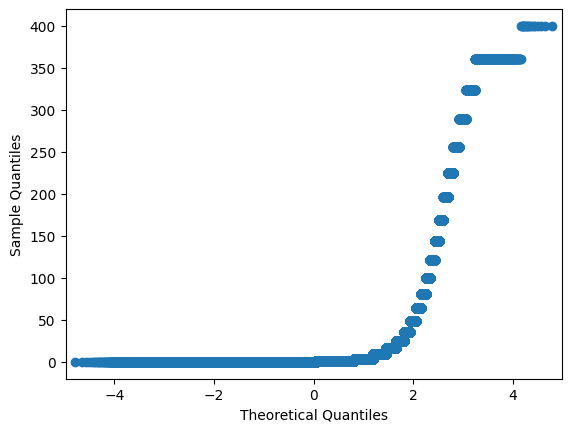

In [8]:
sm.qqplot(monthly_sales['mse']);

# 2. Filter specifically for store-item combos that we have seen before

In [9]:
first_time = monthly_sales.groupby(by=['shop_id', 'item_id'])['month'].shift(1).isna() # remove first_time ones effectively removes section 0 (mostly seciton 1 remaining)
monthly_sales['first'] = first_time